In [ ]:
pip install torch torchvision

In [ ]:
pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-esnlggip
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-esnlggip
  Running command git checkout -q 9585a58d10cb2efcd159b058fa4af914203c1d0d
     |████████████████████████████████| 49 kB 2.8 MB/s 
     |████████████████████████████████| 596 kB 18.5 MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.6.0-cp37-cp37m-linux_x86_64.whl size=25112328 sha256=9694ccb4b875d4b9d8915703d6522eb8b00ea381088b1412ae42dfc0a2612611
  Stored in directory: /tmp/pip-ephem-wheel-cache-ck2p1qiu/wheels/4c/03/f0/326bb241eb86a155a12f217c81e163fbba48424bb84fa22074
  Created wheel for fvcore: filename=fvcore-0.1.5.post20211023-py3-none-any.whl size=60947 sha256=fcb7d9ef2bbe3f046db7e4bf7616f08f1f028734b6cd628b19c4c4f3637d3da3
  Stored in directory: /root/.cache/pip/wheels/16/98/fc/252d62cab6263c719120e06b28f3378af59b52ce7a20e81852
Successfully built pytor

In [3]:
import pytorch3d as p3d
print(p3d.__version__)

0.6.0


In [10]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)
import numpy as np
from tqdm import tqdm_notebook

# matplotlib
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# デバイス
device = torch.device("cpu")

In [7]:
!wget https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj

--2021-12-07 07:16:05--  https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156763 (153K) [text/plain]
Saving to: ‘dolphin.obj’

dolphin.obj         100%[===================>] 153.09K   605KB/s    in 0.3s    

2021-12-07 07:16:06 (605 KB/s) - ‘dolphin.obj’ saved [156763/156763]



In [8]:
trg_obj = os.path.join('dolphin.obj')

In [11]:
# 頂点と面とauxの取得
verts, faces, aux = load_obj(trg_obj)
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# (0,0,0)を中心とする半径1の球にフィットするように正規化・中心化
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# ターゲットメッシュの生成
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

In [17]:
# ソースメッシュの生成
src_mesh = ico_sphere(4, device)

/usr/local/lib/python3.7/dist-packages/pytorch3d/structures/meshes.py:1108: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self._edges_packed = torch.stack([u // V, u % V], dim=1)


In [13]:
# メッシュのプロット
def plot_pointcloud(mesh, title=""):
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()


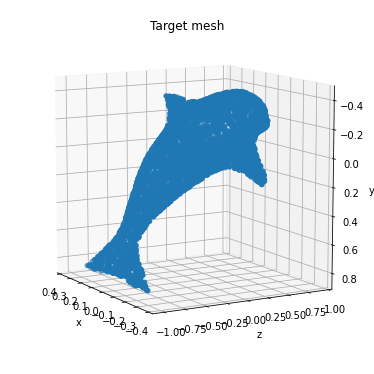

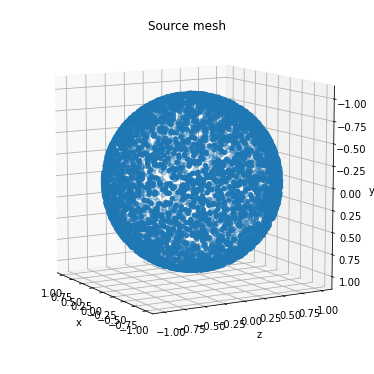

In [16]:
# ターゲットメッシュとソースメッシュのプロット
plot_pointcloud(trg_mesh, "Target mesh")
plot_pointcloud(src_mesh, "Source mesh")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch3d/structures/meshes.py:1108: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self._edges_packed = torch.stack([u // V, u % V], dim=1)


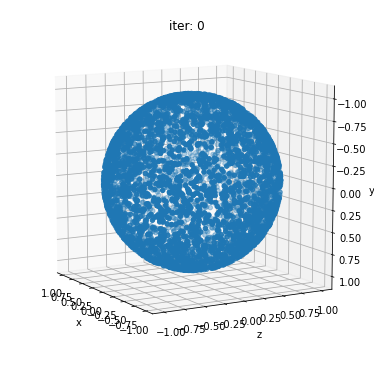

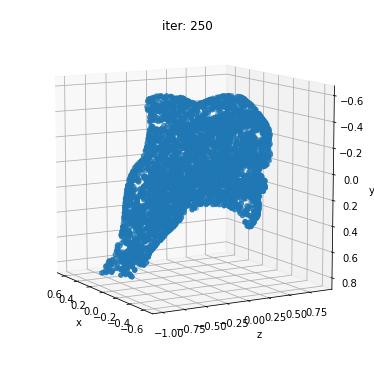

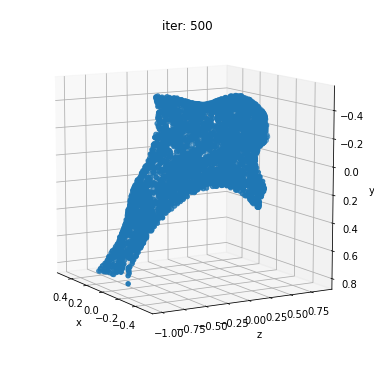

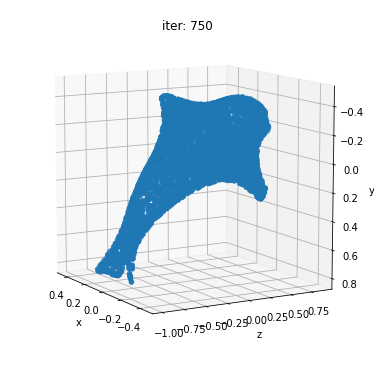

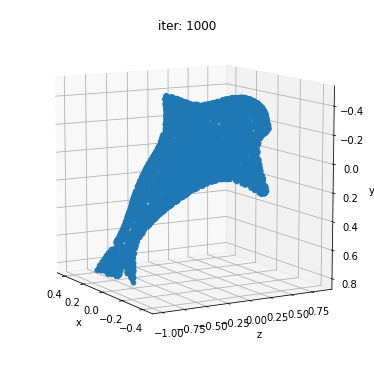

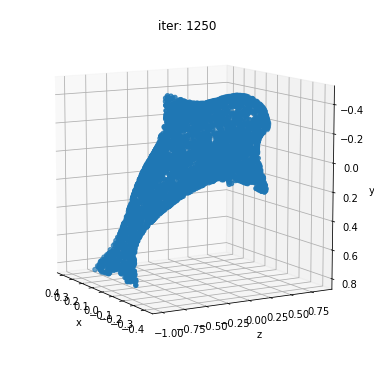

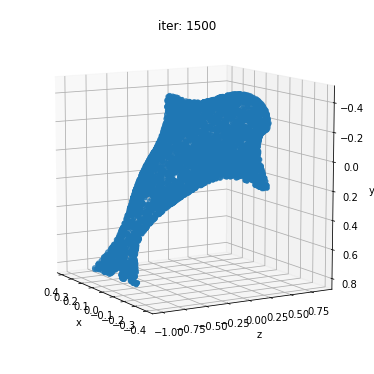

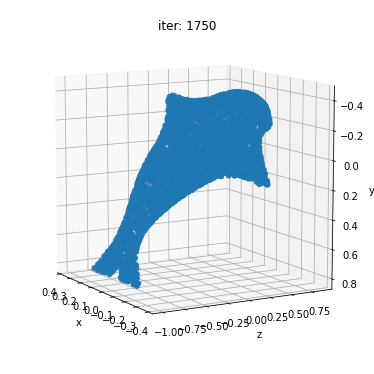

In [15]:
# 変換関数の形状は、src_meshの頂点数と同じ
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)

# オプティマイザ
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

Niter = 2000 # 最適化ステップの数
w_chamfer = 1.0 # chamfer loss の重み
w_edge = 1.0 # edge lossの重み
w_normal = 0.01 # mesh normal consistencyの重み
w_laplacian = 0.1 # mesh laplacian smoothingの重み
plot_period = 250 # プロット頻度
loop = tqdm_notebook(range(Niter))

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

%matplotlib inline

for i in loop:
    # オプティマイザの初期化
    optimizer.zero_grad()

    # メッシュの変形
    new_src_mesh = src_mesh.offset_verts(deform_verts)

    # 各メッシュの表面から5000個の点をサンプリング
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)

    # chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

    # edge loss
    loss_edge = mesh_edge_loss(new_src_mesh)

    # normal loss
    loss_normal = mesh_normal_consistency(new_src_mesh)

    # laplacian loss
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")

    # 損失の加重合計
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian

    # 損失の出力
    loop.set_description('total_loss = %.6f' % loss)

    # プロットのための損失の保存
    chamfer_losses.append(loss_chamfer)
    edge_losses.append(loss_edge)
    normal_losses.append(loss_normal)
    laplacian_losses.append(loss_laplacian)

    # メッシュのプロット
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)

    # 最適化ステップ
    loss.backward()
    optimizer.step()

Text(0.5, 1.0, 'Loss vs iterations')

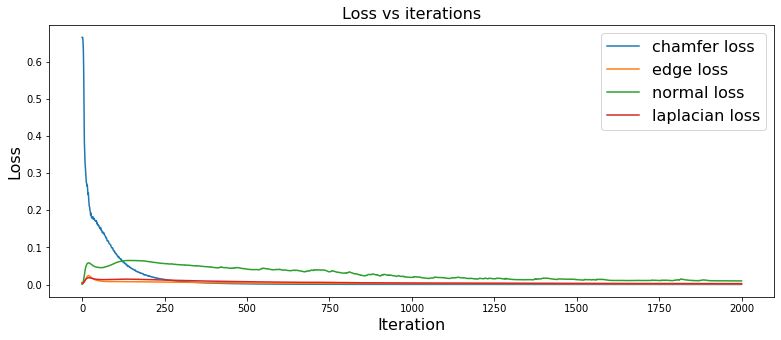

In [18]:
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16")